Homework 3
===
112022526 林郁昇

Import required modules.

In [1]:
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt

Write your fermonic operators.\
Build your own Fermi-Hubbard operator.
---

The Fermi-Hubbard model can be written as

$$
H_{FH}=
-\sum_{i,j,\sigma}t_{ij}
(c^{\dag}_{i\sigma}c_{j\sigma}+c^{\dag}_{j\sigma}c_{i\sigma})
+\sum_{i}U_{i}\frac{n_{i}(n_{i}-1)}{2}
+\sum_{i,j}V_{ij}n_{i}n_{j}
-\sum_{i}\varepsilon_{i}n_{i}.
$$

Before write down the fermonic operators and Fermi-Hubbard hamiltonian, let 
me specify how I write down the base states. The base states I use are the 
same as the teacher's lecture

$$
|\underline{1\uparrow}, \underline{1\downarrow}, \underline{2\uparrow}, 
\underline{2\downarrow}, \underline{3\uparrow}, \cdots, 
\underline{N\uparrow}, \underline{N\downarrow}>.
$$

Therefore, construct fermonic operators are easy as the shown in lecture

$$
\hat{c}_{i}=
\underbrace{\hat{\sigma}_{z}\otimes\cdots\otimes\hat{\sigma}_{z}}_{i-1}
\otimes\hat{c}\otimes
\underbrace{\hat{1}\otimes\cdots\otimes\hat{1}}_{N-i}
$$

and the number operator

$$
\hat{n}_{i}=
\hat{n}_{i\uparrow}+\hat{n}_{i\downarrow}=
\hat{c}^{\dag}_{i\uparrow}\hat{c}_{i\uparrow}+
\hat{c}^{\dag}_{i\downarrow}\hat{c}_{i\downarrow}.
$$

Now, let discuss how I construct general case Fermi-Hubbard hamiltonian.
For a $N$ sites of Fermi Hubbard hamiltonian, each sites have 2 spin 
direction and each spin have zero or one electron. Therefore, the dimension 
of the matrix is $(2\times2)^{N}$. This information is stored in the variable
"dims". Then, I defined two operators that is corresponding to the ladder
operator $\hat{c}_{i}$ and number operator $\hat{n}_{i}$. The way I construct 
these two operators is shown in the above discussion. Next is the four 
core functions, namely tunnel coupling, charging energy, inter-site 
interaction and local energy offset. For each function, I define an empty
matrix by using "qutip.qzero(dims)", then add each term by for loop. Finally,
add these four function up to get the full hamiltonian.

Because the homework requirement only need to change energy detuning. 
I define a new function, "h_fh_detune", that can insert the changeless 
variables into the Fermi Hubbard hamiltonian function in advance for 
the convenient. Also, we only need to consider the two-particle states, 
this function also constract the hamiltonian by the specific basis.

In [2]:
def fermi_hubbard_hamiltonian(sites, tunnel, charging, intersite, localenergy):
    dims = [2 for _ in range(2 * sites)]

    def c_isig(i, sigma):
        ind = 2 * i + 1 + sigma
    
        if ind - 1 != 0:
            cisig = qu.sigmaz()

            for _ in range(ind - 2):
                cisig = qu.tensor(cisig, qu.sigmaz())
        
            cisig = qu.tensor(cisig, qu.destroy(2))
    
        else:
            cisig = qu.destroy(2)

        for _ in range(2 * sites - ind):
            cisig = qu.tensor(cisig, qu.qeye(2))

        return cisig
    
    def ni(i):
        return c_isig(i, 0).dag() * c_isig(i, 0) + \
            c_isig(i, 1).dag() * c_isig(i, 1)

    def tunnel_hamiltonian():
        h_tunnel = qu.qzero(dims)

        for i in range(sites):
            for j in range(i + 1, sites):
                for sig in range(2):
                    h_tunnel -= tunnel[i, j] * \
                        (c_isig(i, sig).dag() * c_isig(j, sig) + \
                            c_isig(j, sig).dag() * c_isig(i, sig))

        return h_tunnel

    def charging_hamiltonian():
        h_charging = qu.qzero(dims)

        for i in range(sites):
            h_charging += (charging[i] / 2) * ni(i) * (ni(i) - 1)
        
        return h_charging

    def intersite_hamiltonian():
        h_intersite = qu.qzero(dims)

        for i in range(sites):
            for j in range(i + 1, sites):
                h_intersite += intersite[i, j] * ni(i) * ni(j)

        return h_intersite

    def localenergy_hamiltonian():
        h_localenergy = qu.qzero(dims)

        for i in range(sites):
            h_localenergy -= localenergy[i] * ni(i)

        return h_localenergy
    
    h_tunnel = tunnel_hamiltonian()
    h_charging = charging_hamiltonian()
    h_intersite = intersite_hamiltonian()
    h_localenergy = localenergy_hamiltonian()

    h_fermihubbard = h_tunnel + h_charging + h_intersite + h_localenergy

    return h_fermihubbard

def h_fh_detune(sites, basis, tunnel, charging, intersite):
    def h(localenergy):
        hamiltonian = fermi_hubbard_hamiltonian(sites, tunnel, charging, 
                                                intersite, localenergy)

        reduce_h = np.zeros([len(basis) for _ in range(2)], dtype=np.cfloat)
        for i in range(len(basis)):
            for j in range(len(basis)):
                reduce_h[i, j] = hamiltonian.matrix_element(basis[i],
                                                            basis[j])
        
        reduce_h = qu.Qobj(reduce_h)

        return reduce_h
    return h

This section is to test whether the function work properly. Of course, the
result is the same as the lecture. Note how I defined the detuning.

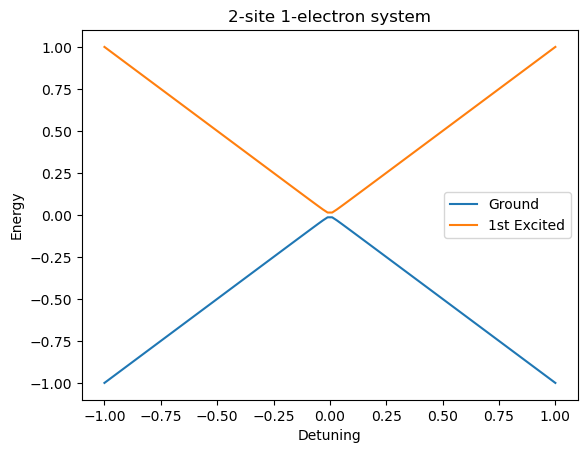

In [3]:
sites = 2
basis = [qu.ket('1000'), qu.ket('0010'), qu.ket('0100'), qu.ket('0001')]

tunnel = np.array([[0, 0.01],
                   [0.01, 0]])
charging = np.array([1, 1])
intersite = np.array([[0, 1],
                      [1, 0]])

detuning = np.linspace(- 1, 1, 100)

h_fh = h_fh_detune(sites, basis, tunnel, charging, intersite)

eigenenergy = []
for ind, detune in enumerate(detuning):
    localenergy = np.array([- detune, detune])

    h = h_fh(localenergy)

    eigen_energy, eigen_state = h.eigenstates()

    eigenenergy.append(eigen_energy)

eigenenergy = np.array(eigenenergy)

plt.figure()
plt.plot(detuning, eigenenergy[:, 0])
plt.plot(detuning, eigenenergy[:, 2])
plt.legend(['Ground', '1st Excited'])
plt.xlabel('Detuning')
plt.ylabel('Energy')
plt.title('2-site 1-electron system')
plt.show()

Plot the energy diagram vs detuning for two-particle states
---

First, defined the sites, basis, and four coefficient for the 
Fermi-Habbard hamiltonian, and plug into the function, "h_fh_detune", for 
later use. Next, use for loop to find the eigenenergy for each detune.
Finally, plot the figure. Note that the detune we defind here is different 
from the case for 1 electron.

We can see when the detune is 0, the result is same as the homework 2. The 
first, second, and third excited are degenerate at all time.

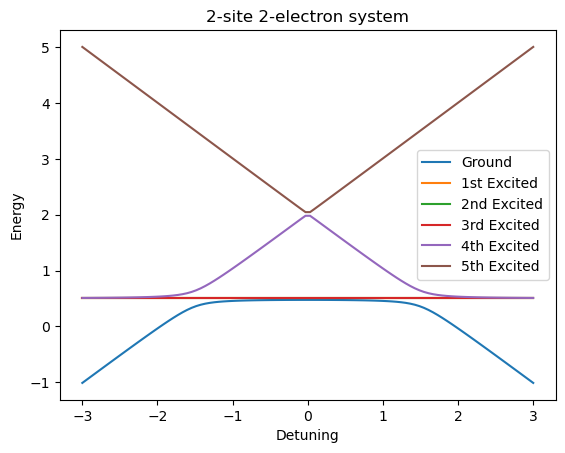

In [4]:
sites = 2
basis = [qu.ket('1010'), qu.ket('0101'), qu.ket('1001'), qu.ket('0110'), 
         qu.ket('1100'), qu.ket('0011')]

tunnel = np.array([[0, 0.1],
                   [0.1, 0]])
charging = np.array([2, 2])
intersite = np.array([[0, 0.5],
                      [0.5, 0]])

detuning = np.linspace(- 3, 3, 100)

h_fh = h_fh_detune(sites, basis, tunnel, charging, intersite)

eigenenergy = []
for ind, detune in enumerate(detuning):
    localenergy = np.array([- detune / 2, detune / 2])

    h = h_fh(localenergy)

    eigen_energy, eigen_state = h.eigenstates()

    eigenenergy.append(eigen_energy)

eigenenergy = np.array(eigenenergy)

plt.figure()
plt.plot(detuning, eigenenergy)
plt.legend(['Ground', '1st Excited', '2nd Excited', '3rd Excited',
            '4th Excited', '5th Excited'])
plt.xlabel('Detuning')
plt.ylabel('Energy')
plt.title('2-site 2-electron system')
plt.show()

Obtain the charge stability diagram of a double dot.
---

For a physical system, the electron are more likely in the system's ground
state. So, we can compute the system's ground state in different local energy 
offset. Then, apply the number operator to the ground state to see how much 
electrons in one of the quantum dots.

If we use the Fermi Hubbard hamiltonian defined above to calculate the 
charge stability diagram, there will only have a few honeycone. Because we 
assume each sites have only one modes, which means each sites can have at 
most 2 electrons. It only takes 4 electrons to fill it up. To increase 
the electrons into the system, we have to increase the modes for each sites.
Therefore, I define the basis states as

$$
|\underline{1_{1}\uparrow}, \underline{1_{1}\downarrow},
\underline{1_{2}\uparrow}, \underline{1_{2}\downarrow}, \cdots,
\underline{1_{M}\uparrow}, \underline{1_{M}\downarrow},
\underline{2_{1}\uparrow}, \underline{2_{1}\downarrow}, \cdots, 
\underline{2_{M}\uparrow}, \underline{2_{M}\downarrow}, \cdots,
\underline{N_{1}\uparrow}, \underline{N_{1}\downarrow}, \cdots,
\underline{N_{M}\uparrow}, \underline{N_{M}\downarrow}>,
$$

where the subscript stand for the modes. Now, the dimension become 
$(2\times 2\times M)^{N}$, which is very large when both the sites and modes
increased.

The ladder operator can be defined as the above section. However, 
the number operator need to sum over all the modes

$$
\hat{n}_{i}=
\hat{n}_{i,1\uparrow}+\hat{n}_{i,1\downarrow}+
\hat{n}_{i,2\uparrow}+\hat{n}_{i,2\downarrow}+\cdots
\hat{n}_{i,M\uparrow}+\hat{n}_{i,M\downarrow}.
$$

Also, for the tunnel coupling term, we have to sum over each modes. Hence, 
they have a extra for loop.

Because the sites and modes are fixed in this system, I defined an operator, 
"n_operator", that can input these two arguments beforehand for convenience. 
This situation also happen in the Fermi Hubbard hamiltonian.

The last function is for drawing purpose. To see the transition of the 
step-like function is to plot the derivative of the function.

In [2]:
def fermi_hubbard_hamiltonian(sites, modes, tunnel, charging, 
                              intersite, localenergy):
    dims = [2 for _ in range(2 * sites * modes)]

    def c_isig(i, m, sigma):
        ind = 2 * modes * i + 2 * m + 1 + sigma

        if ind - 1 != 0:
            cisig = qu.sigmaz()

            for _ in range(ind - 2):
                cisig = qu.tensor(cisig, qu.sigmaz())
            
            cisig = qu.tensor(cisig, qu.destroy(2))
        
        else:
            cisig = qu.destroy(2)
        
        for _ in range(2 * sites * modes - ind):
            cisig = qu.tensor(cisig, qu.qeye(2))
        
        return cisig

    def ni(i):
        n = qu.qzero(dims)

        for j in range(modes):
            n += c_isig(i, j, 0).dag() * c_isig(i, j, 0) + \
                c_isig(i, j, 1).dag() * c_isig(i, j, 1)

        return n

    def tunnel_hamiltonian():
        h_tunnel = qu.qzero(dims)

        for i in range(sites):
            for j in range(i + 1, sites):
                for k in range(modes):
                    for sig in range(2):
                        h_tunnel -= tunnel[i, j] * \
                            (c_isig(i, k, sig).dag() * c_isig(j, k, sig) + \
                                c_isig(j, k, sig).dag() * c_isig(i, k, sig))
        
        return h_tunnel

    def charging_hamiltonian():
        h_charging = qu.qzero(dims)

        for i in range(sites):
            h_charging += (charging[i] / 2) * ni(i) * (ni(i) - 1)

        return h_charging

    def intersite_hamiltonian():
        h_intersite = qu.qzero(dims)

        for i in range(sites):
            for j in range(i + 1, sites):
                h_intersite += intersite[i, j] * ni(i) * ni(j)

        return h_intersite

    def localenergy_hamiltonian():
        h_localenergy = qu.qzero(dims)

        for i in range(sites):
            h_localenergy -= localenergy[i] * ni(i)

        return h_localenergy

    h_tunnel = tunnel_hamiltonian()
    h_charging = charging_hamiltonian()
    h_intersite = intersite_hamiltonian()
    h_localenergy = localenergy_hamiltonian()

    h_fermihubbard = h_tunnel + h_charging + h_intersite + h_localenergy

    return h_fermihubbard

def n_operator(sites, modes):
    dims = [2 for _ in range(2 * sites * modes)]

    def c_isig(i, m, sigma):
        ind = 2 * modes * i + 2 * m + 1 + sigma

        if ind - 1 != 0:
            cisig = qu.sigmaz()
            
            for _ in range(ind - 2):
                cisig = qu.tensor(cisig, qu.sigmaz())

            cisig = qu.tensor(cisig, qu.destroy(2))

        else:
            cisig = qu.destroy(2)
        
        for _ in range(2 * sites * modes - ind):
            cisig = qu.tensor(cisig, qu.qeye(2))
        
        return cisig

    def ni(i):
        n = qu.qzero(dims)

        for j in range(modes):
            n += c_isig(i, j, 0).dag() * c_isig(i, j, 0) + \
                c_isig(i, j, 1).dag() * c_isig(i, j, 1)
        
        return n
    return ni

def h_fh_local(sites, modes, tunnel, charging, intersite):
    def h(localenergy):
        return fermi_hubbard_hamiltonian(sites, modes, tunnel, charging,
                                         intersite, localenergy)
    return h

def numdiff(electron_number):
    diffx = np.sum(np.abs(electron_number - \
        np.roll(electron_number, 1, axis=0)), axis=2)
    diffy = np.sum(np.abs(electron_number - \
        np.roll(electron_number, 1, axis=1)), axis=2)
    
    diff = diffx + diffy
    diff[0, :] = 0
    diff[-1, :] = 0
    diff[:, 0] = 0
    diff[:, -1] = 0
    
    return diff

Here, I plot 2 sites with each have 2 modes. The dimension of the matrix is 
about $(2\times2\times2)^{2}=64$, which is very large and very consume 
computation power. In order to compute $100\times100$ local energy offset
It takes around 50 mins. That why I only consider 2 modes for each sites.

As for the program first defined the parameter, including sites, modes, 
tunnel coupling, charging energy, inter-site interaction, and local 
energy offset. Then, put the changless parameter into the pre-defined 
operator for convenience. Next, calculate the eigenstate and the number of 
electron. Finally, plot the result.

To accelerate the computation time, we can decomposed the hamiltonian into 
several pieces, because we know the number of electrons is conserved. 
Also, we can use multiprocccess module to parallel computing the for loop. 
However, I don't want to. LOL

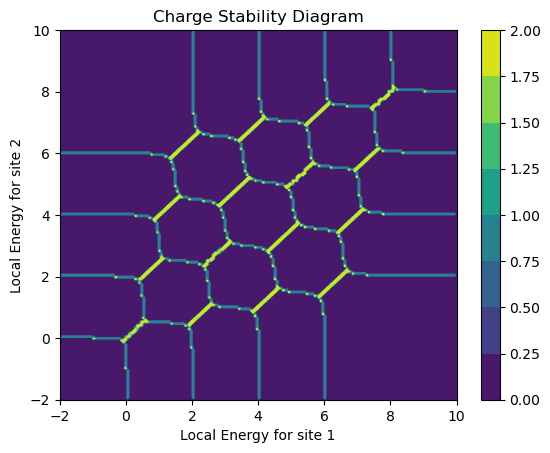

In [6]:
sites = 2
modes = 2

tunnel = np.array([[0, 0.1],
                   [0.1, 0]])
charging = np.array([2, 2])
intersite = np.array([[0, 0.5],
                      [0.5, 0]])

localenergy1 = np.linspace(- 2, 10, 200)
localenergy2 = np.linspace(- 2, 10, 200)

h_fh = h_fh_local(sites, modes, tunnel, charging, intersite)
n_op = n_operator(sites, modes)

electron_number = np.zeros([len(localenergy1), len(localenergy2), sites])

for ind1, local1 in enumerate(localenergy1):
    for ind2, local2 in enumerate(localenergy2):
        localenergy = np.array([local1, local2])
        h = h_fh(localenergy)

        eigen_energy, eigen_state = h.eigenstates()

        for i in range(sites):
            num = eigen_state[0].dag() * n_op(i) * eigen_state[0]

            electron_number[ind1, ind2, i] = np.round(num.norm())

charge_stability = np.transpose(numdiff(electron_number))

plt.figure()
plt.contourf(localenergy1, localenergy2, charge_stability)
plt.colorbar()
plt.xlabel('Local Energy for site 1')
plt.ylabel('Local Energy for site 2')
plt.title('Charge Stability Diagram')
plt.show()

Or, I can still plot each sites with only one mode.

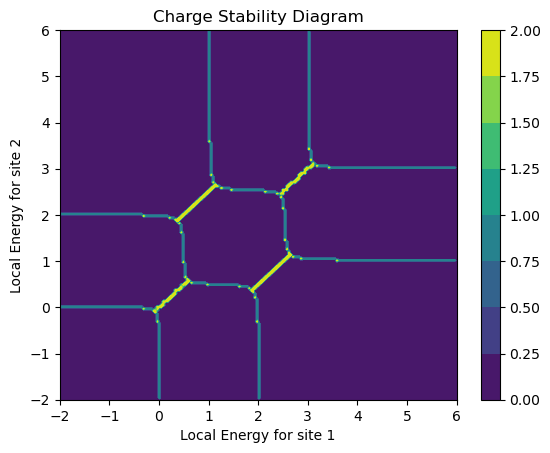

In [3]:
sites = 2
modes = 1

tunnel = np.array([[0, 0.1],
                   [0.1, 0]])
charging = np.array([2, 2])
intersite = np.array([[0, 0.5],
                      [0.5, 0]])

localenergy1 = np.linspace(- 2, 6, 200)
localenergy2 = np.linspace(- 2, 6, 200)

h_fh = h_fh_local(sites, modes, tunnel, charging, intersite)
n_op = n_operator(sites, modes)

electron_number = np.zeros([len(localenergy1), len(localenergy2), sites])

for ind1, local1 in enumerate(localenergy1):
    for ind2, local2 in enumerate(localenergy2):
        localenergy = np.array([local1, local2])
        h = h_fh(localenergy)

        eigen_energy, eigen_state = h.eigenstates()

        for i in range(sites):
            num = eigen_state[0].dag() * n_op(i) * eigen_state[0]

            electron_number[ind1, ind2, i] = np.round(num.norm())

charge_stability = np.transpose(numdiff(electron_number))

plt.figure()
plt.contourf(localenergy1, localenergy2, charge_stability)
plt.colorbar()
plt.xlabel('Local Energy for site 1')
plt.ylabel('Local Energy for site 2')
plt.title('Charge Stability Diagram')
plt.show()